In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 64

train_dl = DataLoader(MNIST(root='./MNIST_data', train=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(MNIST(root='./MNIST_data', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

torch.Size([1, 28, 28])


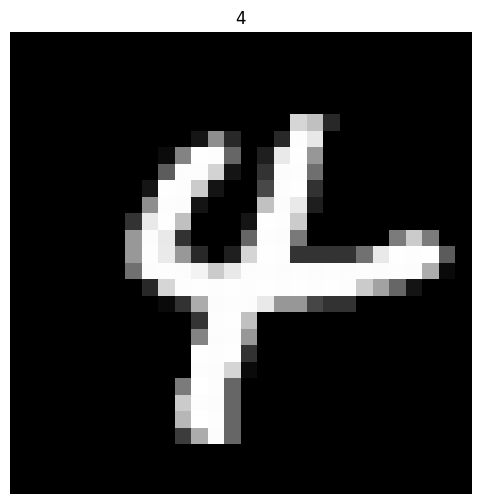

In [4]:
import matplotlib.pyplot as plt

# Get the first batch of images
images, labels = next(iter(train_dl))
image, label = images[0], labels[0]
print(image.shape)

# Reshape and convert to numpy array for plotting
image = image.squeeze().numpy()

# Create a figure and display the image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(f'{label}')
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
class DDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2056),
            nn.ReLU(),
            nn.Linear(2056, 2056),
            nn.ReLU(),
            nn.Linear(2056, 2056),
            nn.ReLU(),
            nn.Linear(2056, 2056),
            nn.ReLU(),
            nn.Linear(2056, 28*28)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
model = DDPM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10

In [8]:
losses = {}

for epoch in range(epochs):
    epoch_losses = []
    for batch in train_dl:
        x, y = batch
        batch_size = x.shape[0]
        x = x.cuda().reshape(batch_size, 28*28)

        noise_level = torch.rand(batch_size, 1, device=x.device)
        noise = torch.randn_like(x, device=x.device)
        noisy_x = x * (1 - noise_level) + noise * noise_level

        optimizer.zero_grad()
        loss = F.mse_loss(model(noisy_x), target=x)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    losses[epoch] = epoch_losses
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Epoch 1/10, Loss: 0.04573298245668411
Epoch 2/10, Loss: 0.04129784181714058
Epoch 3/10, Loss: 0.0371117889881134
Epoch 4/10, Loss: 0.04016633704304695
Epoch 5/10, Loss: 0.03887248784303665
Epoch 6/10, Loss: 0.03901560604572296
Epoch 7/10, Loss: 0.04205742105841637
Epoch 8/10, Loss: 0.02885260246694088
Epoch 9/10, Loss: 0.04075891152024269
Epoch 10/10, Loss: 0.04027339443564415


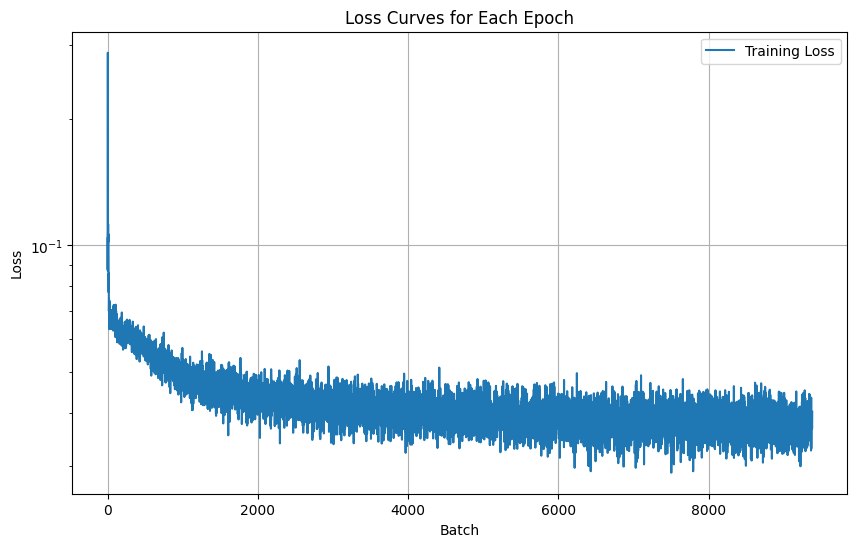

In [9]:
# Create loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Append all the losses
all_losses = []
for epoch_losses in losses.values():
    all_losses.extend(epoch_losses)

# Plot the losses
plt.plot(all_losses, label='Training Loss')


plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss Curves for Each Epoch')
plt.legend()
plt.yscale('log')  # Using log scale for better visualization
plt.grid(True)
plt.show()


In [27]:
def sample(model, bs: int = 9, steps: int = 100):
    x = torch.randn(bs, 28*28).to(device)

    pred_weight = 4/steps
    x_weight = 1 - pred_weight

    for _ in range(steps):
        pred = model.forward(x)
        x = x * x_weight + pred * pred_weight
    return x

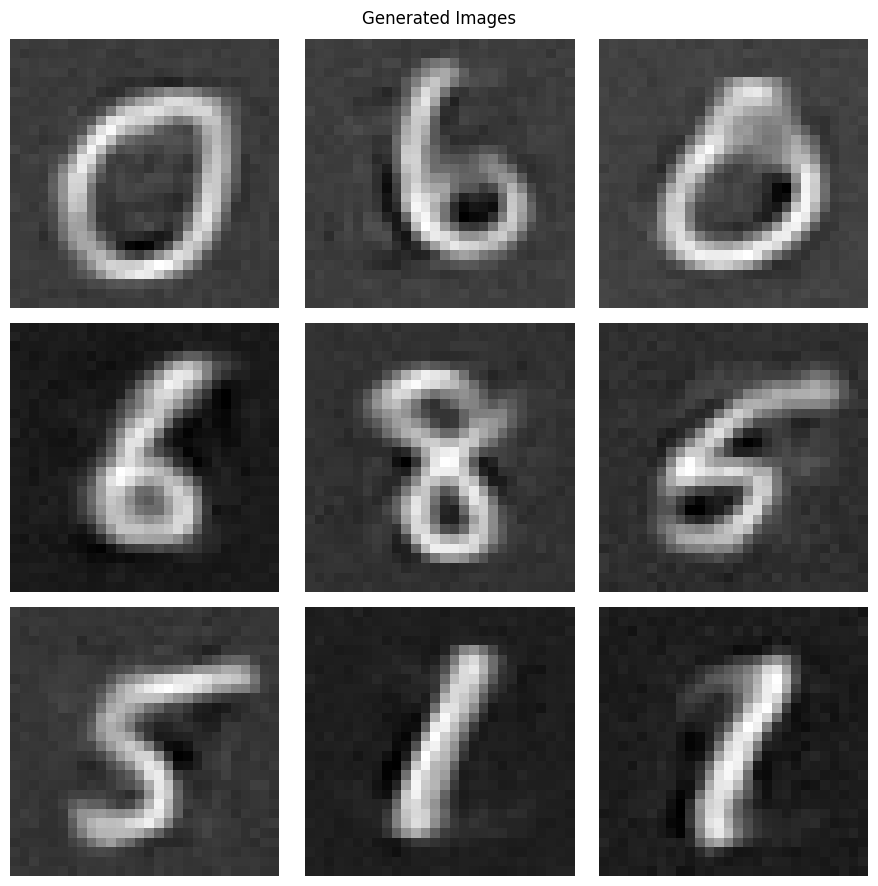

In [28]:
imgs = sample(model, 9, 100)

# Plot images in 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
fig.suptitle('Generated Images')

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        img = imgs[i].reshape(28, 28).detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


